In [1]:
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import json
from pathlib import Path
from typing import Dict
import numpy as np
from shapely import geometry


def iou_relative_quads(quad1, quad2):
    """
    Вычисляет Intersection over Union между двумя четырехугольниками.
    Четырехугольники должны быть представлены в относительном масштабе [0..1].
    В вычислении IoU учитывается только площадь в пределах значений [0..1].
    """
    quad1 = geometry.Polygon(quad1)
    quad2 = geometry.Polygon(quad2)

    # IoU вычисляется только в рамках кадра
    frame = geometry.Polygon([
        [0, 0],
        [0, 1],
        [1, 1],
        [1, 0]
    ])
    if not (quad1.is_valid and quad2.is_valid):
        return 0.0
    try:
        return (quad1 & quad2 & frame).area  / ((quad1 | quad2) & frame).area
    except Exception as exc:
        return 0.0

def dump_results_dict(unique_key2quad_dict: Dict, filename: Path):
    """
    Сохраняет значения словаря {"ключ": четырехугольник} в файл.
    """
    data = dict(
        (k, np.array(v).tolist())
        for (k, v) in unique_key2quad_dict.items()
    )
    with open(filename, 'w') as f:
        f.write(json.dumps(data))


def read_results_dict(filename: Path):
    """
    Читает значения словаря {"ключ": четырехугольник} из файла.
    """
    with open(filename, 'r') as f:
        return json.loads(f.read())


def measure_crop_accuracy(
    pred_filename: Path, gt_filename: Path,
    assert_same_keys:bool = False, iou_thr=0.95
    ):
    pred = read_results_dict(pred_filename)
    gt = read_results_dict(gt_filename)
    if assert_same_keys:
        assert set(pred.keys()) == set(gt.keys()), "Keys mismatch in gt/pred dicts"

    ious = []
    for key, gt_quad in gt.items():
        if key in pred:
            pred_quad = pred[key]
            ious.append(iou_relative_quads(gt_quad, pred_quad))
        else:
            ious.append(0)
    ious = np.array(ious)
    accuracy = (ious > iou_thr).astype(int).sum() / len(ious)
    return accuracy


def _run_evaluation():
    base = Path(__file__).absolute().parent.parent
    gt_path = base / 'gt.json'
    pred_path = base / 'pred.json'
    score = measure_crop_accuracy(pred_path, gt_path)
    print("Accuracy[IoU>0.95] = {:1.4f}".format(score))

In [3]:
from dataclasses import dataclass
import json
from pathlib import Path
from typing import List
import warnings

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from PIL import Image

@dataclass
class DataItem:
    """
    Изображение с разметкой-четырехугольником кропа.
    """
    gt_path: Path
    img_path: Path

    @property
    def unique_key(self):
        return "|".join(self.gt_path.parts[-4:])

    @property
    def image(self) -> Image:
        return Image.open(self.img_path)

    @property
    def gt_data(self)->dict:
        if hasattr(self, '_gt_data'):
            return self._gt_data

        try:
            with open(self.gt_path, 'r') as f:
                self._gt_data = json.loads(f.read())
        except UnicodeDecodeError as exc:
            # в оригинальных пакетах есть в шаблонах текст в не UTF-8 кодировках, например
            # китайский; этот текст не нужен для задания
            warnings.warn(f"Can't read {self.gt_path}, non unicode text", UnicodeWarning)
            self._gt_data = dict()
        return self._gt_data

    @property
    def quadrangle(self)->np.array:
        gt_data = self.gt_data
        if 'quad' in gt_data:
            quad = np.array(self.gt_data['quad']).astype(float)
            quad /= self.image_size[None]
            return quad
        return None

    @property
    def image_size(self):
        if not hasattr(self, '_image_size'):
            self._image_size = np.array(self.image.size).astype(float)
        return self._image_size

    def is_correct(self) -> bool:
        """
        Проверяет, существуют ли файлы изображения и разметки, и если да,
        то есть ли в файле разметки данные четырехугольника.
        Для разметки 'шаблона', т.е. идеально кропнутого изображения, лежащего в корне,
        этих дданных нет, потому что quad = [(0,0), (0,w), (h,w), (0,h)].
        """
        exists =  (self.gt_path.exists()) and (self.img_path.exists())
        return exists and ('quad' in self.gt_data)

    def show(self, quad01=None):
        """
        Отрисовывает четырехугольник кропа поверх изображения,
        либо quad01, либо quadrangle из разметки.
        quad01 должен быть в относительно масштабе (min ~ 0, max ~ 1).
        """
        fig, ax = plt.subplots()
        ax.imshow(np.array(self.image))
        if quad01 is None:
            quad01 = self.quadrangle
        quad = quad01 * self.image_size[None]
        p = patches.Polygon(quad, edgecolor = 'r', fill=False)
        ax.add_patch(p)

    def is_quad_inside(self) -> bool:
        """
        Находится ли четырехугольник разметки полностью внутри кадра.
        """
        assert self.is_correct(), "Incorrect item quad is undefined"
        return np.all(0 <= self.quadrangle) and np.all( self.quadrangle <= 1)

    def is_test_split(self) -> bool:
        """
        Принадлежит ли итем к test-разделу датасета.
        Правило разделения train/test следующее:
        - если итем принадлежит пакету с номером [44:50], то это test split
        - если итем в последовательности имеет номера [26:30], то это test split
        Таким образом, в тесте есть:
        ~ 7 * 300=2100 итемов, для которых не было примеров во время тренировки
        ~ 43 * (5/30) * 10=2150 итемов, чей которых были примеры во время тренировки
        Всего 4150 итемов.
        """
        assert self.is_correct(), "Incorrect item split is undefined"
        package_num = int(self.gt_path.parent.parent.parent.name.split('_')[0])
        sequence_num = int(self.gt_path.stem.split('_')[-1])

        if 25 < sequence_num <= 30:
            return True

        if 43 < package_num <= 50:
            return True
        return False

    def iou_with(self, pred_quad01: np.array) -> float:
        assert self.is_correct(), "Can't measure iou for incorrect item"
        return iou_relative_quads(self.quadrangle, pred_quad01)

    def __repr__(self):
        return f"DataItem<{self.gt_path}|{self.img_path}>"


class MidvPackage:
    """
    Один пакет данных MIDV-500.
    Контейнер для DataItem, лежащих в одном корневом
    """
    GT_SUBDIR = 'ground_truth'
    IMG_SUBDIR = 'images'

    @classmethod
    def read_midv500_dataset(cls, dataset_root:Path)->List['MidvPackage']:
        """Читает весь датасет MIDV-500 (список из пакетов 50)"""
        if not isinstance(dataset_root, Path):
            raise TypeError(f"Expected pathlib.Path type, got {type(dataset_root)}")
        package_paths = [p for p in dataset_root.glob("*") if p.is_dir()]
        return [cls(p) for p in package_paths]

    def __init__(self, root: Path):
        for subdir in (self.GT_SUBDIR, self.IMG_SUBDIR):
            assert (root / subdir).exists(), f"{self.root} does not contain '{subdir}'"

        self.root = root
        self.items = self.collect_items(root)
        self.template_item = self.collect_template(root)

    @classmethod
    def collect_items(cls, root_path: Path) -> List[DataItem]:
        """
        Собирает все DataItem в пакете, кроме шаблона.
        """
        items = []
        gt_root = root_path / cls.GT_SUBDIR
        img_root = root_path / cls.IMG_SUBDIR

        gt_paths = list(gt_root.rglob("*.json"))
        img_paths = [x for x in list(img_root.rglob("*")) if not x.is_dir() and not '.ipynb' in str(x)]

        key = lambda x: str(x.parent / x.stem)
        key_to_img, key_to_gt = dict(), dict()
        for p in gt_paths:
            key_to_gt[key(p.relative_to(gt_root))] = p
        for p in img_paths:
            key_to_img[key(p.relative_to(img_root))] = p

        simg = set(key_to_img.keys())
        sgt =  set(key_to_gt.keys())
        assert simg == sgt, f"{simg - sgt}, {sgt - simg}"
        for k, img_path in key_to_img.items():
            gt_path = key_to_gt[k]
            items.append(DataItem(gt_path=gt_path, img_path=img_path))
        return [it for it in items if it.is_correct()]

    @classmethod
    def collect_template(cls, root_path: Path) -> DataItem:
        """
        Возвращает DataItem-шаблон пакета. Не
        """
        gt_path = root_path / cls.GT_SUBDIR / (root_path.name + ".json")
        assert gt_path.exists(), f"Expected {gt_path} to be template gt, but it does not exist"

        img_path = None
        for ext in (".png", ".tif"):
            _img_path = root_path / cls.IMG_SUBDIR / (root_path.name + ext)
            if (_img_path.exists()):
                img_path = _img_path
        assert img_path is not None, "Expected to find template img, but it does not exist"
        return DataItem(gt_path=gt_path, img_path=img_path)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx]

    def __repr__(self):
        return f"DataPackage[{self.root}]({len(self)})"

#  Подготовка данных

In [4]:
!pip install midv500
import midv500
# set directory for dataset to be downloaded
dataset_dir = 'midv500_data/'

# download and unzip the base midv500 dataset
dataset_name = "midv500"
midv500.download_dataset(dataset_dir, dataset_name)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

01_alb_id.zip:   3%|▎         | 22.3M/657M [00:03<01:41, 6.24MB/s]


KeyboardInterrupt: 

In [4]:
import pathlib
data_packs = MidvPackage.read_midv500_dataset(pathlib.Path('/content/midv500_data/midv500'))

In [5]:
data_packs[0][0].quadrangle.shape

(4, 2)

In [6]:
train_imgs = []
test_imgs = []

for item in tqdm(data_packs):
    for i in range(len(item)):
        if item[i].quadrangle.shape != (4, 2):
          continue
        if not item[i].is_test_split():
            train_imgs.append(item[i])
        else:
            test_imgs.append(item[i])

100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


In [7]:
import albumentations as A

test_transform = A.Compose(
    [
     A.Resize(256, 256),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))],
    keypoint_params=A.KeypointParams(format='xy')
)

In [8]:
import torch
import numpy as np
import scipy.ndimage as ndimage

# функция применения гауссового фильтра вокруг точек, для более корректной работы классификации
def gaussian_fade(image, sigma=2):
    image_np = image.numpy()

    output = np.zeros_like(image_np)

    for i in range(1):
        channel = image_np[i]

        points = channel == 1

        faded_channel = np.zeros_like(channel)

        for y, x in np.argwhere(points):
            temp_img = np.zeros_like(channel)
            temp_img[y, x] = 1
            blurred = ndimage.gaussian_filter(temp_img, sigma=sigma, mode='constant', cval=0)
            faded_channel = np.maximum(faded_channel, blurred)

        output[i] = faded_channel

    return torch.from_numpy(output)


In [9]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
import torch

class MidvDataset(Dataset):
  def __init__(self, items, transform=None):
    self.transform = transform
    self.items = items

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):

    img, target = np.array(self.items[idx].image).astype(np.uint8), self.items[idx].quadrangle
    target[:, 0] = np.clip(target[:, 0], 0, 1)
    target[:, 1] = np.clip(target[:, 1], 0, 1)
    target *= [255, 255]
    res = np.zeros((256, 256, 1))
    for x, y in target:
      res[int(y), int(x), :] = 1

    trans = self.transform(image=np.array(img), keypoints=target)
    return torch.tensor(trans['image']).permute(2, 0, 1), gaussian_fade(torch.tensor(res).permute(2, 0, 1))

In [10]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ], keypoint_params=A.KeypointParams(format='xy')
)

test_transform = A.Compose(
    [
     A.Resize(256, 256),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))],
    keypoint_params=A.KeypointParams(format='xy')
)

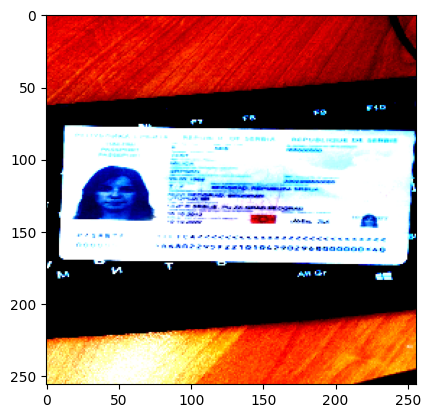

In [11]:
train_dataset = MidvDataset(train_imgs, train_transform)
test_dataset = MidvDataset(test_imgs, test_transform)
item = train_dataset[40]
plt.imshow(item[0].permute(1, 2, 0))

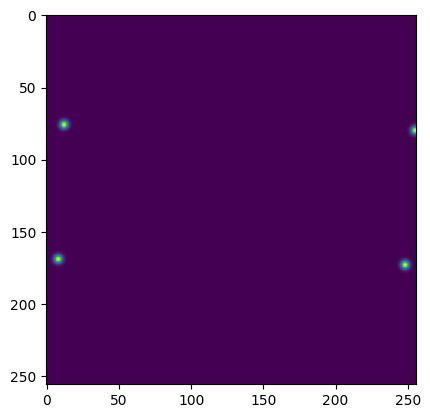

In [12]:
plt.imshow(item[1].permute(1, 2, 0))

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Модель

Возьму в качестве базовой модель UNET

In [13]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

def pool():
    return nn.MaxPool2d(2)

def upconv(in_ch, out_ch):
    return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

# UNet model with concise structure
class UNet(nn.Module):
    def __init__(self, n_ch, n_cls):
        super(UNet, self).__init__()
        self.d1 = conv_block(n_ch, 64)
        self.d2 = conv_block(64, 128)
        self.d3 = conv_block(128, 256)
        self.d4 = conv_block(256, 512)
        self.d5 = conv_block(512, 1024)
        self.pool = pool()

        self.drop = nn.Dropout(0.3)

        self.u6 = upconv(1024, 512)
        self.u7 = upconv(512, 256)
        self.u8 = upconv(256, 128)
        self.u9 = upconv(128, 64)
        self.e6 = conv_block(1024, 512)
        self.e7 = conv_block(512, 256)
        self.e8 = conv_block(256, 128)
        self.e9 = conv_block(128, 64)

        self.final = nn.Conv2d(64, n_cls, 1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



    def forward(self, x):
        c1 = self.d1(x)
        p1 = self.pool(c1)
        c2 = self.d2(p1)
        p2 = self.pool(c2)
        c3 = self.d3(p2)
        p3 = self.pool(c3)
        c4 = self.d4(p3)
        p4 = self.pool(c4)
        c5 = self.d5(p4)

        c5 = self.drop(c5)

        u6 = self.u6(c5)
        c6 = self.e6(torch.cat([u6, c4], 1))
        c6 = self.drop(c6)
        u7 = self.u7(c6)
        c7 = self.e7(torch.cat([u7, c3], 1))
        u8 = self.u8(c7)
        c8 = self.e8(torch.cat([u8, c2], 1))
        u9 = self.u9(c8)
        c9 = self.e9(torch.cat([u9, c1], 1))

        out = self.final(c9)
        return F.softmax(out.view(out.size(0), out.size(1), -1), dim=-1).view(out.size(0), out.size(1), 256, 256)


In [18]:
torch.randn(2, 1, 3, 3)

tensor([[[[-1.6575,  0.6982, -0.1708],
          [-1.1533, -0.8998, -0.5510],
          [-0.5188,  0.7084, -1.1676]]],


        [[[-0.4205,  1.3742,  0.4999],
          [ 0.6823, -0.9742, -0.7622],
          [ 0.4748,  2.0537,  0.0654]]]])

In [15]:
model = UNet(3, 1).cuda()
# with torch.no_grad():
  # print(model(next(iter(train_dataloader))[0].cuda()).shape)

In [41]:
import torch
torch.cuda.empty_cache()

# Обучение модели

In [294]:
from re import VERBOSE
epochs = 5
# model = UNet(3, 1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss(reduction='mean')
losses_train =[]
losses_test =[]

for i in range(epochs):
    loss_ep_train = 0
    pred_ep_train = 0

    loss_ep_test = 0
    pred_ep_test = 0
    model.train()

    for x, y in tqdm(train_dataloader):
        pred = model(x.cuda())
        loss = loss_fn(pred.float(), y.cuda().float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ep_train += loss
        print(loss * 256**2)

    scheduler.step()
    print(scheduler.get_last_lr())
    model.eval()
    for x, y in tqdm(test_dataloader):
        with torch.no_grad():
            pred = model(x.cuda())
            loss = loss_fn(pred.float(), y.cuda().float())
            loss_ep_test += loss

    losses_train.append(loss_ep_train.item())
    losses_test.append(loss_ep_test.item())

    print(losses_train[-1], losses_test[-1])

  0%|          | 1/215 [00:03<11:13,  3.15s/it]

tensor(22.4395, device='cuda:0', grad_fn=<MulBackward0>)


  1%|          | 2/215 [00:06<11:00,  3.10s/it]

tensor(21.9624, device='cuda:0', grad_fn=<MulBackward0>)


  1%|▏         | 3/215 [00:09<11:01,  3.12s/it]

tensor(21.4075, device='cuda:0', grad_fn=<MulBackward0>)


  2%|▏         | 4/215 [00:12<10:52,  3.09s/it]

tensor(22.2981, device='cuda:0', grad_fn=<MulBackward0>)


  2%|▏         | 5/215 [00:15<10:47,  3.09s/it]

tensor(22.2014, device='cuda:0', grad_fn=<MulBackward0>)


  3%|▎         | 6/215 [00:18<10:46,  3.09s/it]

tensor(21.0974, device='cuda:0', grad_fn=<MulBackward0>)


  3%|▎         | 7/215 [00:21<10:41,  3.08s/it]

tensor(22.3300, device='cuda:0', grad_fn=<MulBackward0>)


  4%|▎         | 8/215 [00:24<10:35,  3.07s/it]

tensor(21.7900, device='cuda:0', grad_fn=<MulBackward0>)


  4%|▍         | 9/215 [00:27<10:38,  3.10s/it]

tensor(22.5168, device='cuda:0', grad_fn=<MulBackward0>)


  5%|▍         | 10/215 [00:30<10:36,  3.10s/it]

tensor(21.7587, device='cuda:0', grad_fn=<MulBackward0>)


  5%|▌         | 11/215 [00:34<10:34,  3.11s/it]

tensor(22.7363, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 12/215 [00:37<10:30,  3.11s/it]

tensor(22.2583, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 13/215 [00:40<10:28,  3.11s/it]

tensor(21.8935, device='cuda:0', grad_fn=<MulBackward0>)


  7%|▋         | 14/215 [00:43<10:31,  3.14s/it]

tensor(21.4873, device='cuda:0', grad_fn=<MulBackward0>)


  7%|▋         | 15/215 [00:46<10:26,  3.13s/it]

tensor(22.2243, device='cuda:0', grad_fn=<MulBackward0>)


  7%|▋         | 16/215 [00:49<10:26,  3.15s/it]

tensor(21.5196, device='cuda:0', grad_fn=<MulBackward0>)


  8%|▊         | 17/215 [00:53<10:25,  3.16s/it]

tensor(21.7804, device='cuda:0', grad_fn=<MulBackward0>)


  8%|▊         | 18/215 [00:56<10:23,  3.16s/it]

tensor(22.5675, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 19/215 [00:59<10:14,  3.13s/it]

tensor(21.6042, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 20/215 [01:02<10:07,  3.11s/it]

tensor(22.1129, device='cuda:0', grad_fn=<MulBackward0>)


 10%|▉         | 21/215 [01:05<10:03,  3.11s/it]

tensor(21.6129, device='cuda:0', grad_fn=<MulBackward0>)


 10%|▉         | 21/215 [01:06<10:18,  3.19s/it]


KeyboardInterrupt: 

In [349]:
torch.save(model.state_dict(), './model.pth')

In [49]:
it = iter(test_dataloader)

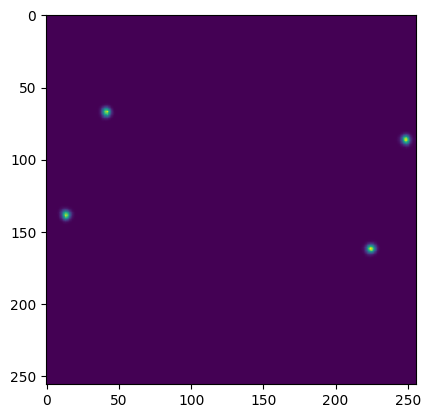

In [335]:
model.eval()
with torch.no_grad():
  res = model(next(it)[0].cuda())[0]
  plt.imshow(res.permute(1, 2, 0).cpu().detach().numpy())

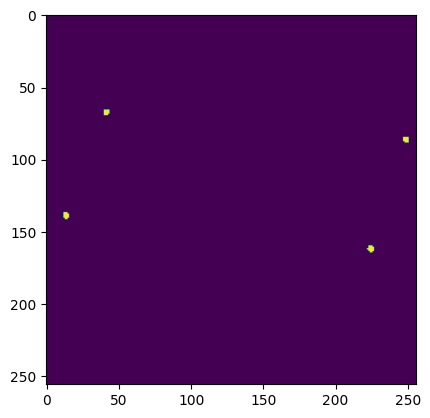

In [336]:
res[res > 0.005] = 1
res[res < 0.005] = 0
plt.imshow(res.permute(1, 2, 0).cpu().detach().numpy())

# Нахождение точек

In [333]:
from sklearn.cluster import KMeans

def get_points(arr):
  input = np.where(arr==1)
  peak_points = np.column_stack(input)
  kmeans = KMeans(n_clusters=4, n_init=50)
  kmeans.fit(peak_points)

  return (kmeans.cluster_centers_ / 255.)[:, :2]

In [337]:
get_points(res.detach().cpu().numpy()[0])

array([[0.54463668, 0.05259516],
       [0.63485839, 0.8795207 ],
       [0.33882353, 0.97490196],
       [0.26431373, 0.16235294]])

# Костыль

мы получаем только сами точки, но нужно еще чтобы они шли в нужном порядке, напишем наивную функцию которая отсортирует в нужном порядке

In [338]:
import numpy as np

def sort_points(points):
    center = points.mean(axis=0)

    output = np.zeros_like(points)
    for i in range(len(points)):
      if points[i][0] - center[0] < 0 and points[i][1] - center[1] < 0:
        output[0] = points[i]
      elif points[i][0] - center[0] > 0 and points[i][1] - center[1] < 0:
        output[1] = points[i]
      elif points[i][0] - center[0] > 0 and points[i][1] - center[1] > 0:
        output[2] = points[i]
      elif points[i][0] - center[0] < 0 and points[i][1] - center[1] > 0:
        output[3] = points[i]
    return output.tolist()



# Итого, финальный пайплайн

In [341]:
def get_res(image):
  image = np.array(image).astype(np.uint8)
  image = torch.tensor(test_transform(image=image, keypoints=np.random.rand(4, 2))['image'])
  image = image.permute(2, 0, 1)
  model.eval()
  with torch.no_grad():
    res = model(image.float().cuda().unsqueeze(0))

  res[res > 0.001] = 1
  res[res < 0.001] = 0

  return sort_points(get_points(res.detach().cpu().numpy()[0, 0])[:, ::-1])

In [342]:
data_packs[21][0].quadrangle

array([[0.18888889, 0.27916667],
       [0.94814815, 0.38854167],
       [0.82685185, 0.65989583],
       [0.06296296, 0.54635417]])

In [346]:
get_res(data_packs[21][0].image)

[[0.18672170622635026, 0.27829377364981106],
 [0.9467320261437911, 0.3847712418300654],
 [0.8264559555165351, 0.6576529119110335],
 [0.058350236646383086, 0.5437457741717376]]

# Получим результат

In [347]:
import warnings
warnings.filterwarnings("ignore")

res_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
              with torch.no_grad():
                  res = get_res(dp[i].image)
              res_dict[dp[i].unique_key] = res

100%|██████████| 50/50 [09:29<00:00, 11.39s/it]


In [348]:
dump_results_dict(res_dict, 'res.json')
acc = measure_crop_accuracy(
    './res.json',
    './gt.json'
)
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.8294
